# Pandemic Stock Price Forecast for Tech Companies
> **Motivation:**  Beginning in March 2020 during the COVID pandemic, the stock market soared. For tech companies, however, this trend was even more pronounced. The purpose of this project is to determine whether it was possible to predict stock prices for the tech sector using Neural Networks

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping

## I) EDA

In [41]:
def candlestick(df, title, begin_year='1975'):
    # Plot candlestick chart
    temp = df[df.index > begin_year]
    fig = go.Figure(data=[go.Candlestick(x=temp.reset_index()['Date'],
                open=temp['Open'],
                high=temp['High'],
                low=temp['Low'],
                close=temp['Adj Close'])])
    
    fig.update_layout(title=title,
                      yaxis_title="USD")

    fig.show()

### a) Analyze the Stock Market
The S&P 500 Index is largely considered an essential benchmark of the stock market. I will analyze it to gain insight about the market

In [127]:
SP500 = yf.download('^GSPC')

[*********************100%***********************]  1 of 1 completed


In [128]:
# Generic plot of S&P 500 stock price 
candlestick(SP500,'S&P 500: Market Summary')

In [84]:
def annual_percent_change(df):
    # Calculates percent annual return
    # Input: df[Date, Open, High, Low, Close, Adj Close]
    # Output: df[Year, Open, High, Low, Close, % Change]] 
    
    years = np.unique(np.array(SP500.index.year))[0:-1]
    percent_change = []
    year_open, year_close = [], [] 
    year_low, year_high = [], []

    for i in years:
        temp = df[(df.index >= str(i)) & (df.index < str(i+1))]['Adj Close']
        percent_change.append(round((temp[-1] / temp[0] - 1) * 100, 2))
        year_open.append(temp[0])
        year_close.append(temp[-1])
        year_low.append(min(temp))
        year_high.append(max(temp))
    
    result = pd.DataFrame({'Date':years, 
                         'Open': year_open,
                         'Close': year_close,
                         'Low': year_low,
                         'High': year_high,
                         '% Change': percent_change}).set_index('Date')
    return result 

SP500_YoY = annual_percent_change(SP500)

In [86]:
average_annual_return = np.mean(temp['% Change'])
SP500_2020 = SP500_YoY[SP500_YoY.index == 2020]['% Change']
SP500_2021 = SP500_YoY[SP500_YoY.index == 2021]['% Change']

SP500_2020, SP500_2021, average_annual_return

(Date
 2020    15.29
 Name: % Change, dtype: float64,
 Date
 2021    28.79
 Name: % Change, dtype: float64,
 8.703472222222219)

> The S&P500 index has delivered an average annual growth rate of 8.7% per year since 1950. However, this rule of thumb did not apply during the pandemic.
> * In 2020, S&P 500 opened at \\$3257.85 and ended at \\$3756.07, which is a **15% increase**.
> * In 2021, S&P 500 opened at \\$3700.65 and ended at \\$4766.18, which is a **29% increase**. 

In [123]:
temp = SP500_YoY[SP500_YoY.index > 1950].reset_index() # Only include recent data, (1950 and beyond)
px.bar(temp, x="Date", y="% Change", title='S&P 500: Percent Annual Growth')

>The plot above shows the percent annual growth in price from 1950 to 2022. If the bar is greater than zero, the index value increased that year. We occasionally see long positive streches, with the longest recent strech being from 1995 to 1999 (dotcom bubble). **The 2019-2022 market is certainly bullish but not particularly special.**

In [167]:
fig = px.histogram(SP500_YoY['% Change'], nbins=20)

fig.add_vline(x=SP500_2020.to_list()[0], annotation_text ='2020')
fig.add_vline(x=SP500_2021.to_list()[0], annotation_text ='2021')

fig.update_layout(title='S&P500: Percent Annual Growth Distribution', xaxis_title='Percent Annual Growth', yaxis_title='Counts')

fig.show()
np.percentile(SP500_2020)

<function numpy.percentile(a, q, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)>

 ### b) Analyzing Tech Stocks
NASDAQ 100 Technology Sector (NDXT) is an index composed of tech companies like Alphabet, Apple, and Meta (Facebook). I will analyze and compare its performance to NASDAQ.

In [274]:
NDXT = yf.download('^NDXT')
candlestick(NDXT, '2000','NDXT')

[*********************100%***********************]  1 of 1 completed


In [284]:
NDXT_2020 = NDXT[(NDXT.index >= '2020-01-01') & (NDXT.index <= '2020-12-31')]['Adj Close']
annual_change_2020 = NDXT_2020[-1] / NDXT_2020[0]
NDXT_2021 = NDXT[(NDXT.index >= '2021-01-01') & (NDXT.index <= '2021-12-31')]['Adj Close']
annual_change_2021 = NDXT_2021[-1] / NDXT_2021[0]
print('In 2020, NDXT increased by ' + str(round((annual_change_2020 - 1) * 100,2)) +'%')
print('In 2021, NDXT increased by ' + str(round((annual_change_2021 - 1) * 100,2)) +'%')

In 2020, NDXT increased by 35.21%
In 2021, NDXT increased by 28.3%


In other words, the tech sector was performing even better than the general market.

### Apple (AAPL) Stock Analysis

In [87]:
full_df = yf.download('^GSPC')

[*********************100%***********************]  1 of 1 completed


In [94]:
# train_df = full_df[(full_df.index > '2020') & (full_df.index < '2021')]
# test_df = full_df[(full_df.index > '2021')]

In [95]:
# Split data into train vs test
n_days = 30 # Forecast closing price n days into the future

numrows_train = round(0.65 * full_df.shape[0])
train_df = full_df[0:numrows_train]
test_df = full_df[numrows_train:]

In [96]:
# Normalize Data between 0 and 1 
scaler = MinMaxScaler(feature_range = (0,1))
adj_close_scaled = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))

In [97]:
# Formatting  data
x_train = []
y_train = []

for i in range(n_days, len(adj_close_scaled)):
    x_train.append(adj_close_scaled[i-n_days:i])
    y_train.append(adj_close_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [98]:
K.clear_session()
model = Sequential()
    
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [99]:
model.fit(x_train, y_train, epochs=12, 
          batch_size = 32)

Epoch 1/12
485/485 [==============================] - 9s 12ms/step - loss: 0.0017
Epoch 2/12
485/485 [==============================] - 6s 12ms/step - loss: 6.4126e-04
Epoch 3/12
485/485 [==============================] - 6s 12ms/step - loss: 5.1125e-04
Epoch 4/12
485/485 [==============================] - 6s 12ms/step - loss: 4.7600e-04
Epoch 5/12
485/485 [==============================] - 6s 12ms/step - loss: 4.4500e-04
Epoch 6/12
485/485 [==============================] - 6s 12ms/step - loss: 4.1940e-04
Epoch 7/12
485/485 [==============================] - 6s 12ms/step - loss: 4.3343e-04
Epoch 8/12
485/485 [==============================] - 6s 12ms/step - loss: 3.8875e-04
Epoch 9/12
485/485 [==============================] - 6s 12ms/step - loss: 3.8614e-04
Epoch 10/12
485/485 [==============================] - 6s 12ms/step - loss: 4.0603e-04
Epoch 11/12
485/485 [==============================] - 6s 12ms/step - loss: 3.7335e-04
Epoch 12/12
485/485 [==============================] - 6

In [100]:
# Normalize test data between 0 and 1 
adj_close_scaled = scaler.transform(test_df['Adj Close'].values.reshape(-1,1))

# Format test data
x_test = []

for i in range(n_days, len(adj_close_scaled)):
    x_test.append(adj_close_scaled[i-n_days:i])

x_test = np.array(x_test)

In [101]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

261/261 [==============================] - 2s 4ms/step


In [102]:
summary_df = test_df[0:test_df.shape[0]-n_days].reset_index()
summary_df['pred'] = predicted_prices

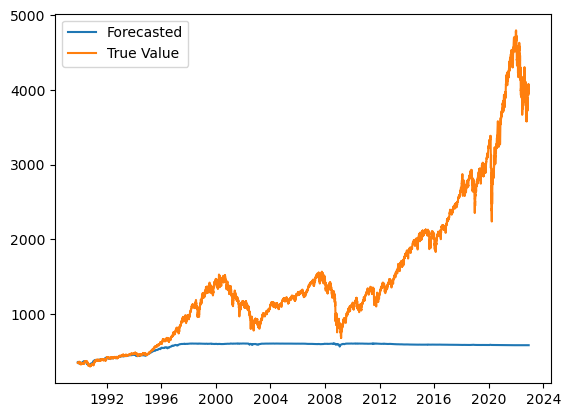

In [103]:
plt.plot(summary_df['Date'], summary_df['pred'], label = 'Forecasted')
plt.plot(summary_df['Date'], summary_df['Adj Close'], label = 'True Value')
plt.legend()
plt.show()

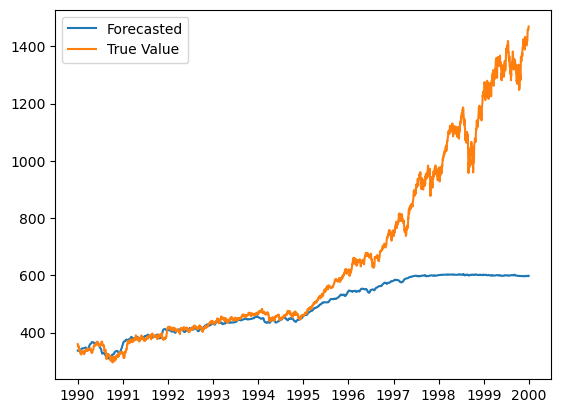

In [105]:
from2008to2014 = summary_df[(summary_df['Date'] > '1990') & (summary_df['Date'] < '2000')]
plt.plot(from2008to2014['Date'], from2008to2014['pred'], label = 'Forecasted')
plt.plot(from2008to2014['Date'], from2008to2014['Adj Close'], label = 'True Value')
plt.legend()
plt.show()